In [1]:
import pandas as pd
import numpy as np
from glob import glob
import os
from os.path import join as opj

In [2]:
csv_dir = "/home/wanjiag/projects/GLACIER/derivatives/csv/"
all_subs = os.listdir(csv_dir)

In [3]:
all_subs.sort()

In [4]:
evc_list = []
ppa_list = []

for sub in all_subs:
    evc_list.append(glob(opj(csv_dir, sub, '*evc*'))[0])
    ppa_list.append(glob(opj(csv_dir, sub, '*ppa*'))[0])

In [5]:
def group_cor(roi_file_list):
    
    roi_corr_df = pd.DataFrame()

    for roi_file in roi_file_list:
        sub_df = pd.read_csv(roi_file, index_col = 0)

        sub_df['run_id'] = sub_df['run'].str.extract('(\d+)').astype(int)
        sub_df['odd_even'] = np.where(sub_df['run_id']%2==0, 0, 1)
        sub_df = sub_df.drop(columns=['run', 'run_id'])

        grouped_sub_df = sub_df.groupby(['sub', 'roi', 'trial', 'odd_even']).mean()
        grouped_sub_df.reset_index(inplace=True)

        odd_df = grouped_sub_df[grouped_sub_df['odd_even'] == 1].reset_index(drop=True)
        even_df = grouped_sub_df[grouped_sub_df['odd_even'] == 0].reset_index(drop=True)

        corr_df = sub_corr(odd_df, even_df)
        roi_corr_df = pd.concat([roi_corr_df, corr_df], ignore_index=True)
    
    return roi_corr_df

In [6]:
def sub_corr(odd_df, even_df):
    
    even_numeric_df = even_df.copy()
    even_numeric_df.columns = pd.to_numeric(even_numeric_df.columns, errors = 'coerce')
    even_numeric_df = even_numeric_df[even_numeric_df.columns.dropna()]
    even_numeric_df.columns = even_numeric_df.columns.astype(int)
    even_nonnumeric_df = even_df.iloc[:,:3]
    
    corr_df = pd.DataFrame()

    for odd in range(odd_df.shape[0]):
        curr_trial = even_nonnumeric_df.copy()
        curr_trial['trial2'] = odd_df.loc[odd,]['trial']

        numeric = odd_df.loc[odd,][4:]
        numeric.index = numeric.index.astype(int)

        curr_trial['corr'] = even_numeric_df.corrwith(numeric.astype(float), axis = 1)
        corr_df = pd.concat([corr_df, curr_trial], ignore_index=True)
    return corr_df

In [50]:
def corr_df_cleaning(corr_df):
    corr_df['trial1_id'] = corr_df['trial'].str.extract('(\d+)')
    corr_df['trial2_id'] = corr_df['trial2'].str.extract('(\d+)')
    
    corr_df['trial1_name'] = corr_df['trial'].str.replace('\d+', '', regex=True) 
    corr_df['trial2_name'] = corr_df['trial2'].str.replace('\d+', '', regex=True) 
    
    corr_df = corr_df.drop(columns = ['trial', 'trial2'])
    
    def category(row):
        
        if (row['trial1_name'] == row['trial2_name']):
            if (row['trial1_id'] == row['trial2_id']):
                return "within_item"
            else:
                return "within_group"
        else:
            return "across_group"

    corr_df.loc[:, 'category'] = corr_df.apply(category, axis = 1)
    
    return corr_df

def calculate_difference(avg_df):
    avg_df_wide = avg_df.pivot(index = 'sub', columns=['category'], values='corr')
    avg_df_wide['within_group-across_group'] = avg_df_wide['within_group']-avg_df_wide['across_group']
    avg_df_wide['within_item-across_group'] = avg_df_wide['within_item']-avg_df_wide['across_group']
    
    avg_df_wide = avg_df_wide.drop(columns = ['across_group', 'within_group', 'within_item']).reset_index()
    
    diff_df = pd.melt(avg_df_wide, id_vars=['sub'], value_vars=['within_group-across_group', 'within_item-across_group'],
                      var_name='category', value_name='corr')
    
    return diff_df

In [8]:
evc_corr_df = group_cor(evc_list)
ppa_corr_df = group_cor(ppa_list)

In [9]:
evc_clean_corr_df = corr_df_cleaning(evc_corr_df)
ppa_clean_corr_df = corr_df_cleaning(ppa_corr_df)

In [11]:
evc_avg_df = evc_clean_corr_df.groupby(['sub', 'roi', 'category'])['corr'].mean().reset_index()
ppa_avg_df = ppa_clean_corr_df.groupby(['sub', 'roi', 'category'])['corr'].mean().reset_index()

In [51]:
evc_diff_df = calculate_difference(evc_avg_df)
ppa_diff_df = calculate_difference(ppa_avg_df)

In [58]:
ppa_diff_df

,sub,category,corr
0,sub-GLACIER01,within_group-across_group,0.005650
1,sub-GLACIER02,within_group-across_group,0.004581
2,sub-GLACIER03,within_group-across_group,0.005004
3,sub-GLACIER04,within_group-across_group,0.002696
4,sub-GLACIER06,within_group-across_group,-0.000486
5,sub-GLACIER07,within_group-across_group,0.004306
6,sub-GLACIER08,within_group-across_group,0.009985
7,sub-GLACIER01,within_item-across_group,-0.000953
8,sub-GLACIER02,within_item-across_group,0.009765
9,sub-GLACIER03,within_item-across_group,0.008655


In [53]:
import seaborn as sns

Text(0.5, 1.0, 'evc')

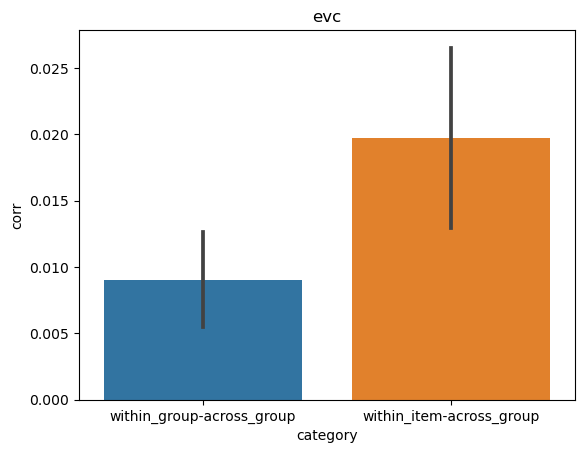

In [54]:
sns.barplot(evc_diff_df, x = 'category', y = 'corr', errorbar='se').set_title(evc_avg_df['roi'][0].split('-')[0])

Text(0.5, 1.0, 'ppa')

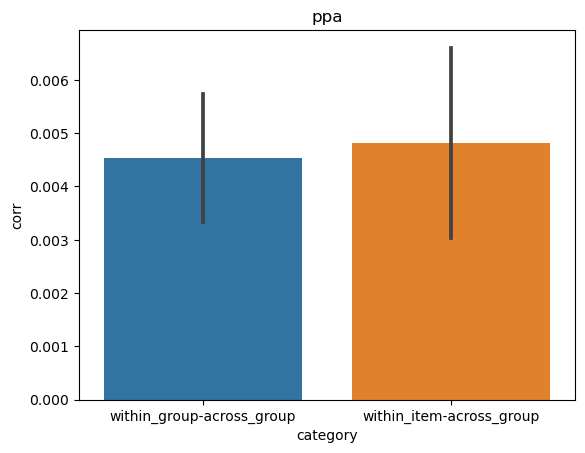

In [55]:
sns.barplot(ppa_diff_df, x = 'category', y = 'corr', errorbar='se').set_title(ppa_avg_df['roi'][0].split('_')[0])